<a href="https://colab.research.google.com/github/clairecoffey/project/blob/master/claire_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fairness and the Bias/Variance Tradeoff 

## Claire Coffey

## 7th May 2020

In this notebook we are studying bias and variance errors in the context of recidivism data. 

## Imports and Setup

Imports: first import the relevant libraries used throughout. 

In [0]:
# imports
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy as np
import pandas as pd

# Read in recidivism data 

In this notebook we are studying recidivism data. We utilise the COMPAS recidivism dataset, which uses recidivism data from Broward County jail and has been explored in the following studies:

"The accuracy, fairness, and limits of predicting recidivism", paper available at:
https://advances.sciencemag.org/content/4/1/eaao5580#corresp-1

"Machine Bias" ProPublica article, available at:
https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing

The dataset used can be found at:
https://github.com/propublica/compas-analysis


Here we import and read in the recidivism data. Currently, we are using a selection of 500 samples from this dataset for our predictions.

We use a selection 
of fields from this dataset to predict recidivism classification (0 = will not reoffend; 1 = will reoffend).

In [0]:

def load_file():
  full_data = False
  print("loading data")
  if full_data:
    # full dataset
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/compas-scores-two-years%20-%20compas-scores-two-years.csv?token=ABPC6VNTFTGQBANNUJY2O4C6XGJGY"
  else:
    # small subset of first 500 people
    file_path = "https://raw.githubusercontent.com/clairecoffey/project/master/mphilproject/500-compas-scores-two-years%20-%20Sheet1%20(1).csv?token=ABPC6VOW7CBEIIGZVE6ZJYS6YKNHO"

  # load CSV contents
  all_data = pd.read_csv(file_path, delimiter=',', dtype={'sex': 'category', 
                                                          'age_cat': 'category',
                                                          'race': 'category',
                                                          'c_charge_degree': 'category',
                                                          'c_charge_desc': 'category',
                                                          'r_charge_degree': 'category',
                                                          'r_charge_desc': 'category',
                                                          'vr_charge_degree': 'category',
                                                          'vr_charge_desc': 'category'
                                                          })
  return all_data


In [0]:
# all_data = load_file()

## Import and process data


We import the data into a pandas DataFrame, where the categorical data is  split into different fields for each category, and encoded as 0 or 1. For example, an individual with characteristic "sex: male" would be encoded as "male: 1, female: 0". The sex category is then removed. 

We then consider which fields to use for prediction. This includes the removal of any fields/columns which contain many NaN values, since these cannot be handled by the classifiers. We choose to remove the columns with many NaNs rather than using an alternative approach such as replacing them with the average so as not to introduce other types of bias. We also then remove rows/individuals containing any further NaN values so there is no longer any NaN values present in the data. 

Finally, we define the number of testing/training samples desired and split the data into these two set appropriately.


In [0]:
from sklearn import preprocessing

def import_data(all_data):

  num_testing_samples = 101

  encoded_sex = (pd.get_dummies(all_data['sex']))
  all_data = all_data.drop(columns=['sex'])
  all_data = all_data.join(encoded_sex)

  encoded_age_cat = (pd.get_dummies(all_data['age_cat']))
  all_data = all_data.drop(columns=['age_cat'])
  all_data = all_data.join(encoded_age_cat)

  encoded_race = (pd.get_dummies(all_data['race']))
  all_data = all_data.drop(columns=['race'])
  all_data = all_data.join(encoded_race)

  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_degree']))
  all_data = all_data.drop(columns=['c_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  #these are joined with suffixes because otherwise columns overlap 
  encoded_c_charge_desc = (pd.get_dummies(all_data['c_charge_desc']))
  all_data = all_data.drop(columns=['c_charge_desc'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_c')

  encoded_c_charge_desc = (pd.get_dummies(all_data['r_charge_degree']))
  all_data = all_data.drop(columns=['r_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_r')

  encoded_r_charge_desc = (pd.get_dummies(all_data['r_charge_desc']))
  all_data = all_data.drop(columns=['r_charge_desc'])
  all_data = all_data.join(encoded_r_charge_desc, rsuffix='_r')

  encoded_c_charge_desc = (pd.get_dummies(all_data['vr_charge_degree']))
  all_data = all_data.drop(columns=['vr_charge_degree'])
  all_data = all_data.join(encoded_c_charge_desc, rsuffix='_vr')

  encoded_vr_charge_desc = (pd.get_dummies(all_data['vr_charge_desc']))
  all_data = all_data.drop(columns=['vr_charge_desc'])
  all_data = all_data.join(encoded_vr_charge_desc, rsuffix='_vr')

  #drop columns not used for predictions, including info such as names, and coluns with many NaN values 
  all_data_simplified = all_data.drop(columns=['two_year_recid', 'r_days_from_arrest', 'id','name','first','last','dob','days_b_screening_arrest','c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date','r_case_number','r_offense_date','r_jail_in','r_jail_out','vr_case_number','vr_offense_date','in_custody','out_custody','start','end','violent_recid'])

  #remove rows containing NaN values 
  all_data_simplified = all_data_simplified.dropna()

  #Renormalise the data so we have unit variance and mean 0 using built-in preprocessing method in sklearn
  scaler = preprocessing.StandardScaler()
  all_data_scaled = pd.DataFrame(scaler.fit_transform(all_data_simplified),columns=all_data_simplified.columns)

  all_data_and_labels = all_data_scaled.join(all_data[['two_year_recid']])

  #split into training and testing with specific number of testing samples
  #for now just set testing set to be first num_testing_samples samples in table 
  testing_data_and_labels = all_data_and_labels[:num_testing_samples]
  #and training set to be the remainder
  #this is also then consistent which is good for seeing patterns etc 
  training_data_and_labels = all_data_and_labels[num_testing_samples:]

  print("normalised")
  print(training_data_and_labels)

  return training_data_and_labels, testing_data_and_labels

In [0]:
# training_data_and_labels, testing_data_and_labels = import_data(all_data)

# Classification

##Selecting Classifiers

Here we select the classification model to use. We are using a selection of built-in classifiers in scikit-learn. 

Currently, we are using RBF SVM models (https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html), with parameters set to C=2 for all, and we vary the gamma value between 0 and 1.


In [0]:
from sklearn import model_selection, neighbors, svm, gaussian_process, tree, ensemble, neural_network, metrics

def define_classifiers():

    #gammas = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26,0.27, 0.28,0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5,
       #       0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9]
    # gammas = [0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5]

    gammas = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]

    # classifiers = [ svm.SVC(gamma=gamma_val, C=2) for gamma_val in gammas ]

    classifiers = []
    for gamma_val in gammas:
      classifiers.append(svm.SVC(gamma=gamma_val,C=2))

    return classifiers, gammas


In [0]:
# define_classifiers()

## Bootstrapping 

The classification process then uses a bootstrapping procedure with the chosen model, to generate predictions of recidivism classifications (1 = will reoffend; 0 = will not reoffend).

Bootstrapping is a sampling with replacement procedure. Here, the sample size is the same as the size of the (training) dataset. The bootstrapping procedure is run many times to generate different training datasets, which will then be used for classification. In turn, the classification results will be used to calculate and study the bias and variance errors. 

In [0]:
def do_bootstrap(training_data_and_labels):
  # this is one bootstrap sample 
  indices = np.random.randint(0,training_data_and_labels.shape[0] , training_data_and_labels.shape[0])
  indices.sort()
  data_points = []

  for i in indices:
    data_points.append(training_data_and_labels.iloc[i])

  b_sample = pd.DataFrame(data_points)

  return b_sample

In [0]:
# b_sample = do_bootstrap(training_data_and_labels)

## Perform classification


Fit the model on the training data (which is one bootstrap data sample as defined above)


In [0]:
def fit_model(clf, b_sample, testing_data_and_labels):

    #training data is everything apart from two year recid 0/1 label from the bootstrap sample
    X_train = b_sample.drop(columns=['two_year_recid'])
    y_train = b_sample['two_year_recid']
    X_test = testing_data_and_labels.drop(columns=['two_year_recid'])
    y_test = testing_data_and_labels['two_year_recid']

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test

    return y_pred, y_true

Perform classification for each bootstrap sample separately, and store these in a DataFrame, to be passed into the bias/variance calculations.

In [0]:
def classify(training_data_and_labels, testing_data_and_labels, clf):
    count = 0

    num_bootstraps = len(training_data_and_labels);
    while count <= num_bootstraps:
      b_sample = do_bootstrap(training_data_and_labels)
      y_pred, y_true = fit_model(clf, b_sample, testing_data_and_labels)
      if(count == 0):
        predictions = pd.DataFrame(pd.Series(y_pred)).transpose()
        #true labels are the same for every sample so we only need 1 row in df
        true_labels = pd.DataFrame(pd.Series(y_true)).transpose()
      else:
        predictions = predictions.append(pd.DataFrame(pd.Series(y_pred)).transpose())
      count += 1
      
    return predictions, true_labels

In [0]:
# classify(training_data_and_labels, testing_data_and_labels, clf)


# Compute bias/variance errors

Using all these bootstrap predictions, we calculate the average misclassification error. This is done by first calculating the overall misclassification loss across bootstrap sample predictions, finding the average misclassification error for each datapoint (individual). As described in:
http://www.cems.uwe.ac.uk/~irjohnso/coursenotes/uqc832/tr-bias.pdf

We can then decompose the error into the errors due to bias, and the errors due to variance, in order to study the behaviour of the model and the bias/variance tradeoff. This decomposition for classification is described in: 
https://homes.cs.washington.edu/~pedrod/bvd.pdf
https://pdfs.semanticscholar.org/9253/f3e13bca7e845e60394d85ddaec0d4cfc6d6.pdf. 

We calculate the bias and variance errors for each individual, following 1/0 rules undermisclassification loss as described in the above paper. We can then calculate the overall average bias error and variance error for the prediction. 


In [0]:
def compute_bias_variance(predictions, true_labels):

  print(predictions)

  biases = []
  variances = []
  avg_errors = []

  # calculate the bias and variance for each value of X,y
  # for misclassification loss

  #find whether each element is misclassified for each bootstrap sample 
  predictions_misclassified = predictions.apply(lambda x : x != true_labels.iloc[0], axis=1)

  #count number of times misclassified for each datapoint across all bootstrap samples 
  counts = predictions_misclassified.apply(np.sum)

  #average misclassification error for each individual/datapoint 
  avg_errors = counts.apply(lambda y : np.divide(y,len(predictions)))
  # print(avg_errors)


  for avg_error in avg_errors:
    (bias, variance) = (0, avg_error) if (avg_error <= 0.5) else (1, (avg_error-1))
    biases.append(bias)
    variances.append(variance)

  avg_bias = np.mean(biases)
  # avg_var = abs(np.mean(avg_errors) - avg_bias)
  avg_var = abs(np.mean(variances))

  print("average bias:")
  print(avg_bias)
  print("average variance:")
  print(avg_var)

  return avg_bias, avg_var

# Plots

Creating the appropriate plots to visualise our results. We plot: 

1.   Bias error vs Variance error
2.   Gamma value of RBF SVM vs Variance error
3.   Gamma value of RBF SVM vs Bias error


In [0]:
import matplotlib.pyplot as plt                                  
def plot_bias_variance(biases, variances, gammas):    
  plt.scatter(biases, variances)                                              
  plt.title('bias vs variance errors')                                     
  plt.xlabel('bias')                                                       
  plt.ylabel('variance')                                                   
  plt.show()

  plt.scatter(gammas, variances)
  plt.xscale('log')                                              
  plt.title('RBF SVM, c = 2 \n gamma size vs variance errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('variance')                                                   
  plt.show()                                                            

  plt.scatter(gammas, biases)                               
  plt.xscale('log')                                                             
  plt.title('RBF SVM, c = 2 \n gamma size vs bias errors')                                     
  plt.xlabel('gamma')                                                       
  plt.ylabel('bias')                                                   
  plt.show()                                                            

# Main method (execute code)

Main method to run the system, executing methods in appropriate sequence. 

In [0]:
def main():
  all_data = load_file()
  training_data_and_labels, testing_data_and_labels = import_data(all_data)
  biases = []
  variances = []
  classifiers, gammas = define_classifiers()

  for classifier in classifiers:
    print(classifier)
    # clf = classifiers[classifier_names.index(classifier)]
    clf = classifier
    predictions, true_labels = classify(training_data_and_labels, testing_data_and_labels, clf)  
    bias, variance = compute_bias_variance(predictions, true_labels)
    biases.append(bias)
    variances.append(variance)

  print("classifications done")
  plot_bias_variance(biases, variances, gammas)


loading data
normalised
          age  juv_fel_count  ...  Robbery W/Firearm_vr  two_year_recid
101 -0.442613      -0.165647  ...             -0.077267               0
102  0.299069      -0.165647  ...             -0.077267               1
103 -0.937067      -0.165647  ...             -0.077267               1
104 -0.442613      -0.165647  ...             -0.077267               0
105 -0.360203      -0.165647  ...             -0.077267               0
..        ...            ...  ...                   ...             ...
332  0.051842      -0.165647  ...             -0.077267               0
333 -0.854658      -0.165647  ...             -0.077267               1
334 -1.019476      -0.165647  ...             -0.077267               0
335 -0.607431      -0.165647  ...             -0.077267               0
336 -1.184294      -0.165647  ...             -0.077267               1

[236 rows x 216 columns]
SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_

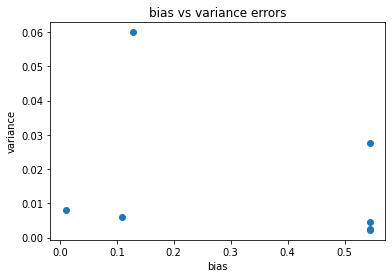

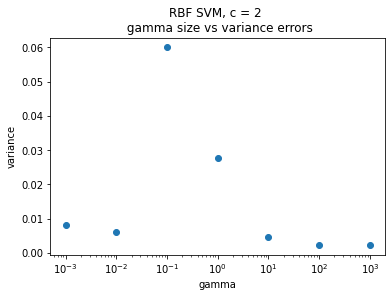

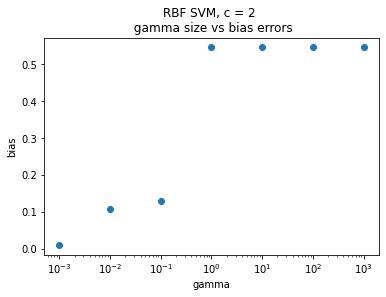

In [188]:
main()